# Checks of TF PV Correlations

Check correlations between PV parameters to ensure dust and k-corrections are properly zeroing out any redshift-dependent biases.

This is a companion to the notebook `TF_iron_internal-dustCorr.ipynb`.

In [1]:
import os
from astropy.table import Table

import numpy as np
from scipy.stats import binned_statistic

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=14)

## Profile Histogram Code

Here we use "profile histogram" in the sense of the ROOT CERN package. This just produces data suitable for plotting in an errorbar plot showing binned statistics (mean, weighted mean, or median) as a function of some independent variable.

In [3]:
def profile_histogram(x, y, xbins, yerr=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Use uncertainties to weight the summary statistics.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if yerr is None:
            raise ValueError('need to define yerr if using weighted fit.')
            
        w = 1/yerr**2
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

def linear_fit(x, y, yerr=None):
    """Perform a linear least squares fit to data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
        
    Returns
    -------
    a : float
        Intercept.
    b : float
        Slope.
    """
    weights = np.ones_like(y) if yerr is None else 1./yerr**2

    #- Create design matrix
    X = np.vstack([np.ones(len(x)), x]).T

    #- Calculate weighted least squares
    W = np.diag(weights)
    coeffs, _, _, _ = np.linalg.lstsq(np.dot(W, X), np.dot(W, y), rcond=None)
        
    return coeffs

## Read Previous and Current Versions of the TF Catalog

Read in the catalog and store some derived data into new tables.

In [4]:
pvpath = os.path.join(os.environ['CFS'], 'desi/science/td/pv/tfgalaxies/Y1')

pvfile1 = os.path.join(pvpath, 'DESI-DR1_TF_pv_cat_v1.fits')
pvdata1 = Table.read(pvfile1)

pvfile3 = os.path.join(pvpath, 'DESI-DR1_TF_pv_cat_v3.fits')
pvdata3 = Table.read(pvfile3)

pvdata1

<Table length=10264>
 SGA_ID    SGA_GALAXY    ...        V_PEC             VERR_PEC     
                         ...        km / s                         
 int64      bytes16      ...       float64            float64      
------- ---------------- ... ------------------- ------------------
     38      SGA-2020 38 ...   718.4016570580498 1019.6978437388899
     55      SGA-2020 55 ...  -466.6876893231274  763.3591724733587
    117     SGA-2020 117 ...    147.186593311646 1817.6523505726223
    223     SGA-2020 223 ...  -322.5550311401803  865.8737552789642
    581     SGA-2020 581 ...   425.5313097049093  834.2401151223459
    669     SGA-2020 669 ... -12833.121793987299 1126.6582699880903
    731     SGA-2020 731 ...   9395.039091626571  923.8865352652873
   1135    SGA-2020 1135 ... -4008.0373280101994  719.8468816352791
   1158    SGA-2020 1158 ...  -800.8634517333012  521.0439882879732
    ...              ... ...                 ...                ...
5002603 SGA-2020 5002603 ... -13243.355475101467  2877.401716560486
5002677 SGA-2020 5002677 ...  2403.3749624204647 3245.0581758084945
5002752 SGA-2020 5002752 ...   57.64207246100705 1213.8600384146155
5002778 SGA-2020 5002778 ... -10953.599684138624  3713.639790936177
5002994 SGA-2020 5002994 ...   583.5269213960946 1317.2509834125838
5003016 SGA-2020 5003016 ...   17876.08884424513  579.5892413744905
5003025 SGA-2020 5003025 ...   9207.375766799902    749.51210520578
5003042 SGA-2020 5003042 ... -2209.8510724217194  5866.636807232018
5003044 SGA-2020 5003044 ... -11060.142958979653  6483.685123741527
5003075 SGA-2020 5003075 ...   4830.935006279662 1294.9342888408282

In [5]:
tab1, tab3 = Table(), Table()

#- Collect data from v1 and v3 of the catalogs
for _t, _p in zip([tab1, tab3], [pvdata1, pvdata3]):
    isdwarf = _p['R_ABSMAG_SB26_TF'] > -17
    
    #- Rotational velocities
    _t['V_0p4R26']     = _p['V_0p4R26'][~isdwarf]
    _t['V_0p4R26_err'] = _p['V_0p4R26_err'][~isdwarf]
    
    _t['logV_0p4R26'] = np.log10(_t['V_0p4R26'])
    _t['logV_0p4R26_err'] = 0.434 * _t['V_0p4R26_err'] / _t['V_0p4R26']
    
    #- R magnitude (apparent and absolute)
    _t['R_ABSMAG_SB26'] = _p['R_ABSMAG_SB26'][~isdwarf]
    _t['R_ABSMAG_SB26_ERR'] = _p['R_ABSMAG_SB26_err'][~isdwarf]
    _t['R_MAG_SB26'] = _p['R_MAG_SB26'][~isdwarf]
    _t['R_MAG_SB26_ERR'] = _p['R_MAG_SB26_ERR'][~isdwarf]
    _t['R_MAG_SB26_CORR'] = _p['R_MAG_SB26_CORR'][~isdwarf]
    _t['R_MAG_SB26_CORR_ERR'] = _p['R_MAG_SB26_ERR_CORR'][~isdwarf]
    
    #- Galaxy colors
    _t['g-r'] = _p['G_MAG_SB26'][~isdwarf] - _p['R_MAG_SB26'][~isdwarf]
    _t['r-z'] = _p['R_MAG_SB26'][~isdwarf] - _p['Z_MAG_SB26'][~isdwarf]
    
    #- Galaxy geometry
    _t['D26'] = _p['D26'][~isdwarf]
    _t['BA'] = _p['BA'][~isdwarf]
    
    #- Redshift and peculiar velocities
    _t['Z_DESI'] = _p['Z_DESI'][~isdwarf]
    _t['V_PEC'] = _p['V_PEC'][~isdwarf]
    _t['VERR_PEC'] = _p['VERR_PEC'][~isdwarf]

## Plot All the Things!

### Peculiar velocity vs redshift

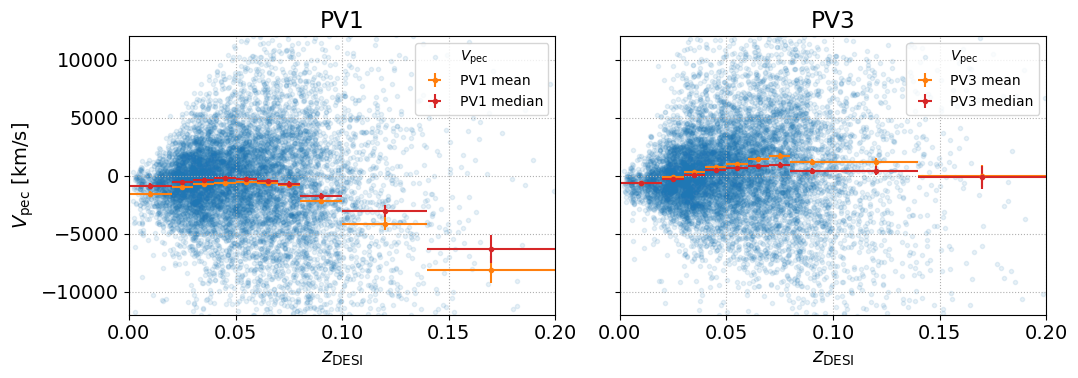

In [6]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1['Z_DESI'], tab1['V_PEC'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV1 mean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 0.2],
       ylim=[-12000, 12000],
       xlabel=r'$z_\text{DESI}$',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3['Z_DESI'], tab3['V_PEC'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab3['Z_DESI'], tab3['V_PEC'], zbins, tab1['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV3 mean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab3['Z_DESI'], tab3['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$z_\text{DESI}$')
ax.grid(ls=':');

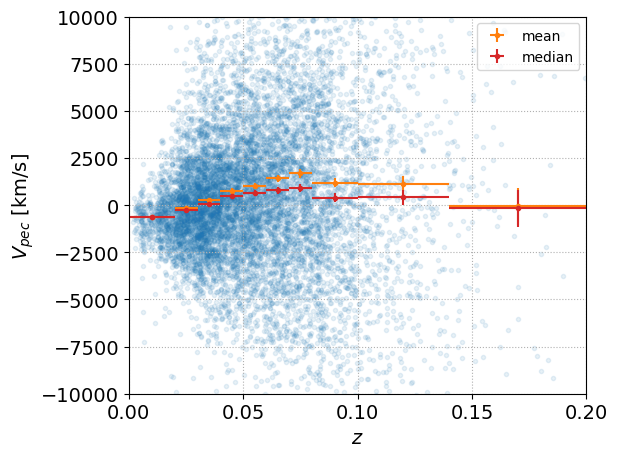

In [14]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

plt.figure(tight_layout=True)

plt.scatter(tab3['Z_DESI'], tab3['V_PEC'], marker='.', alpha=0.1)#, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab3['Z_DESI'], tab3['V_PEC'], zbins, tab1['VERR_PEC'])
plt.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='mean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab3['Z_DESI'], tab3['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
plt.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='median', color='tab:red')

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('$z$')
plt.ylabel('$V_{pec}$ [km/s]')
plt.grid(ls=':')

plt.xlim([0, 0.2])
plt.ylim([-10000, 10000])

plt.savefig('../../Figures/Y1/iron_PV_z_v3.png', dpi=150, facecolor='none');

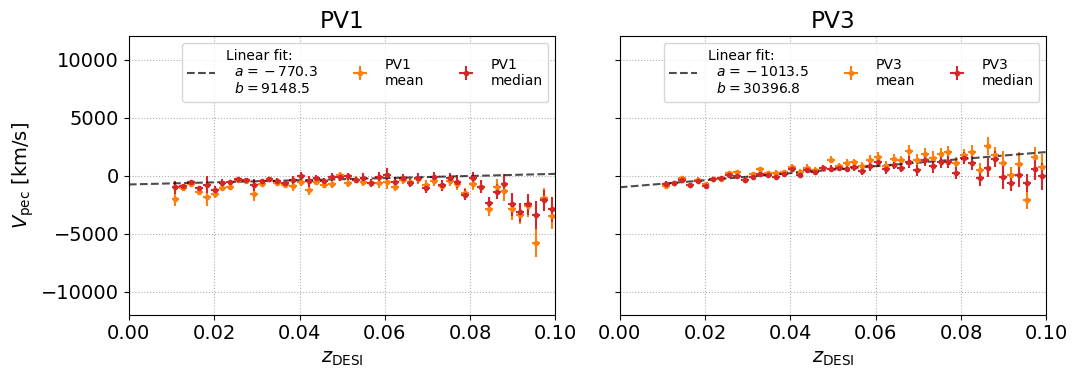

In [7]:
zbins = np.linspace(0.01, 0.1, 50)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV1\nmean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab1['Z_DESI'], tab1['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV1\nmedian', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(zc, vpec_avg, vpec_std)
_z = np.arange(0, 0.11, 0.01)
ax.plot(_z, a + b*_z, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=3)
ax.set(title='PV1',
       xlim=[0, 0.1],
       ylim=[-12000, 12000],
       xlabel=r'$z_\text{DESI}$',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]

#- Plot the mean and median
N, vpec_avg, vpec_std = profile_histogram(tab3['Z_DESI'], tab3['V_PEC'], zbins, tab1['VERR_PEC'])
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV3\nmean', color='tab:orange')
N, vpec_avg, vpec_std = profile_histogram(tab3['Z_DESI'], tab3['V_PEC'], zbins, tab1['VERR_PEC'], median=True)
ax.errorbar(zc, vpec_avg, xerr=dz, yerr=vpec_std, fmt='.', label='PV3\nmedian', color='tab:red')

#- Perform a fit to the median
a, b = linear_fit(zc, vpec_avg, vpec_std)
_z = np.arange(0, 0.11, 0.01)
ax.plot(_z, a + b*_z, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=3)
ax.set(title='PV3',
       xlabel=r'$z_\text{DESI}$')
ax.grid(ls=':')

### r-band magnitude vs axis ratio

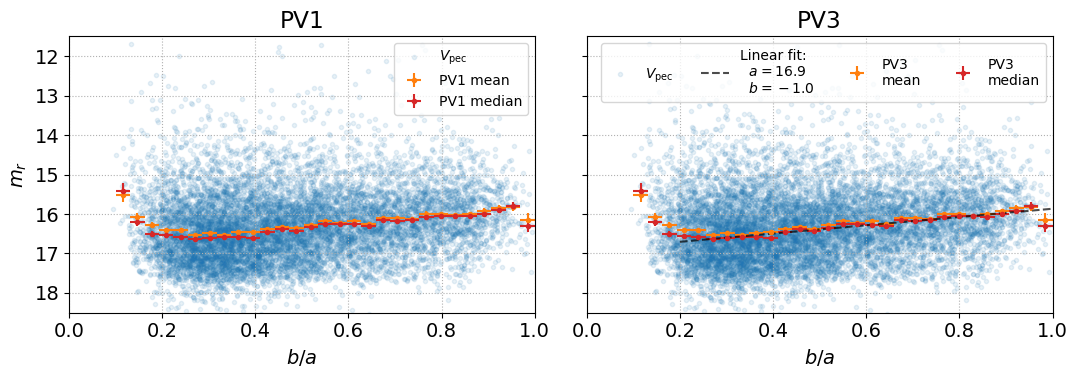

In [8]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1['BA'], tab1['R_MAG_SB26'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1['BA'], tab1['R_MAG_SB26'], xbins, tab1['R_MAG_SB26_ERR'])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1['BA'], tab1['R_MAG_SB26'], xbins, tab1['R_MAG_SB26_ERR'], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[18.5, 11.5],
       xlabel=r'$b/a$',
       ylabel=r'$m_r$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3['BA'], tab3['R_MAG_SB26'], marker='.', alpha=0.1, label='$V_\mathrm{pec}$')

#- Plot the mean and median
N, y_avg, y_std = profile_histogram(tab3['BA'], tab3['R_MAG_SB26'], xbins, tab3['R_MAG_SB26_ERR'])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3\nmean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3['BA'], tab3['R_MAG_SB26'], xbins, tab3['R_MAG_SB26_ERR'], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3\nmedian', color='tab:red')

#- Perform a fit to the median
select = (xc >= 0.2) & (xc <= 0.95)
a, b = linear_fit(xc[select], y_avg[select], y_std[select])
_x = np.arange(0.2, 1.05, 0.05)
ax.plot(_x, a + b*_x, ls='--', color='k', alpha=0.7, label=f'Linear fit:\n  $a={a:.1f}$\n  $b={b:.1f}$')

ax.legend(loc='upper right', fontsize=10, ncol=4)
ax.set(title='PV3',
       xlabel=r'$b/a$')
ax.grid(ls=':')

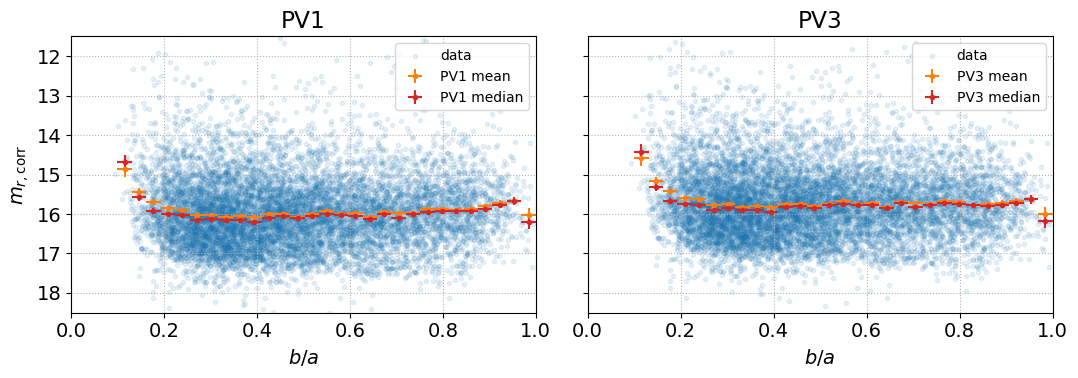

In [9]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'R_MAG_SB26_CORR'
yval_err = 'R_MAG_SB26_CORR_ERR'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[18.5, 11.5],
       xlabel=r'$b/a$',
       ylabel=r'$m_{r,\text{corr}}$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1 on top...
# ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1', color='tab:red')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$b/a$')
ax.grid(ls=':')

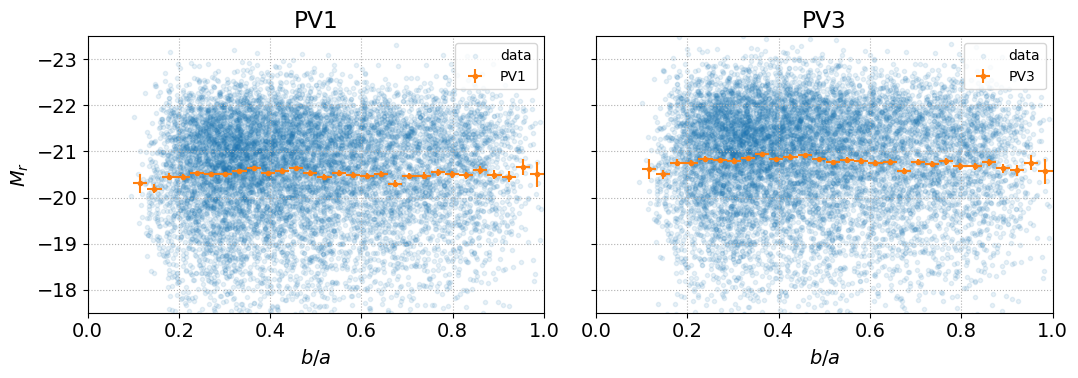

In [10]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'R_ABSMAG_SB26'
yval_err = 'R_ABSMAG_SB26_ERR'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1', color='tab:orange')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[-17.5, -23.5],
       xlabel=r'$b/a$',
       ylabel=r'$M_r$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3', color='tab:orange')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$b/a$')
ax.grid(ls=':')

### Peculiar velocity vs axis ratio and galaxy size

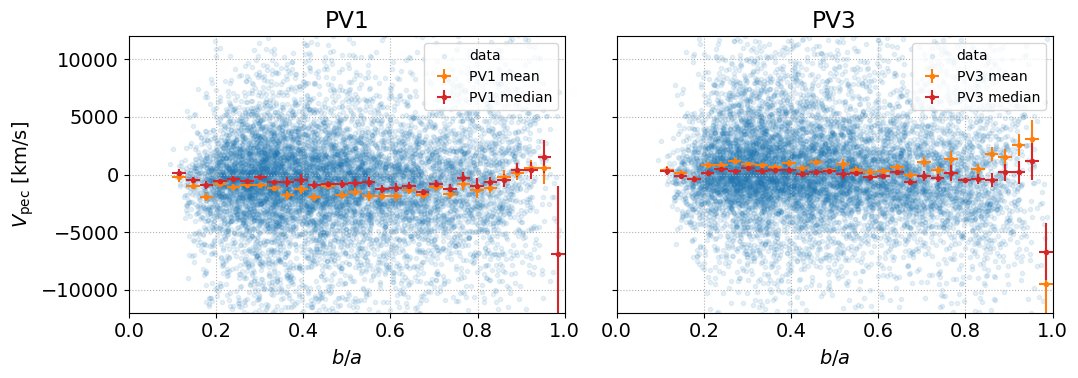

In [11]:
xbins = np.linspace(0.1, 1, 30)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'V_PEC'
yval_err = 'VERR_PEC'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[-12000, 12000],
       xlabel=r'$b/a$',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$b/a$')
ax.grid(ls=':')

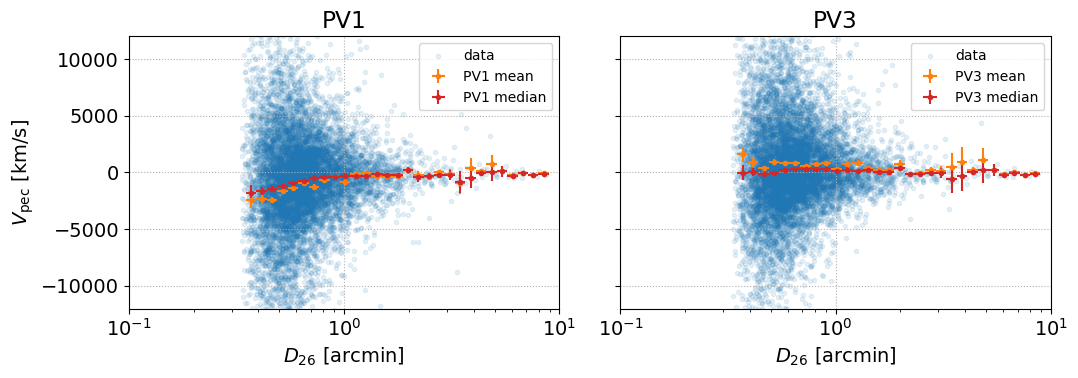

In [12]:
xbins = np.logspace(np.log10(0.35), 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'D26'
yval = 'V_PEC'
yval_err = 'VERR_PEC'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0.1, 10],
       xscale='log',
       ylim=[-12000, 12000],
       xlabel=r'$D_{26}$ [arcmin]',
       ylabel=r'$V_\text{pec}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':')

### Rotational velocity vs galaxy size

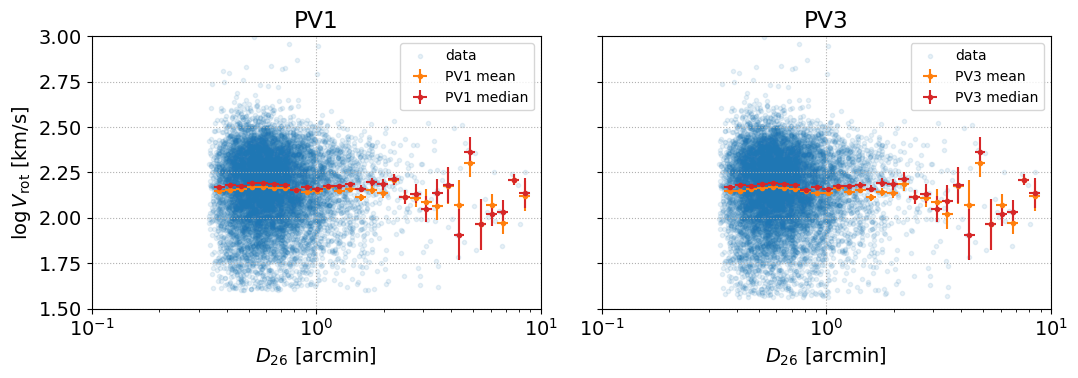

In [13]:
xbins = np.logspace(np.log10(0.35), 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'D26'
yval = 'logV_0p4R26'
yval_err = 'logV_0p4R26_err'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0.1, 10],
       xscale='log',
       ylim=[1.5, 3],
       xlabel=r'$D_{26}$ [arcmin]',
       ylabel=r'$\log{V_\text{rot}}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')


#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':')

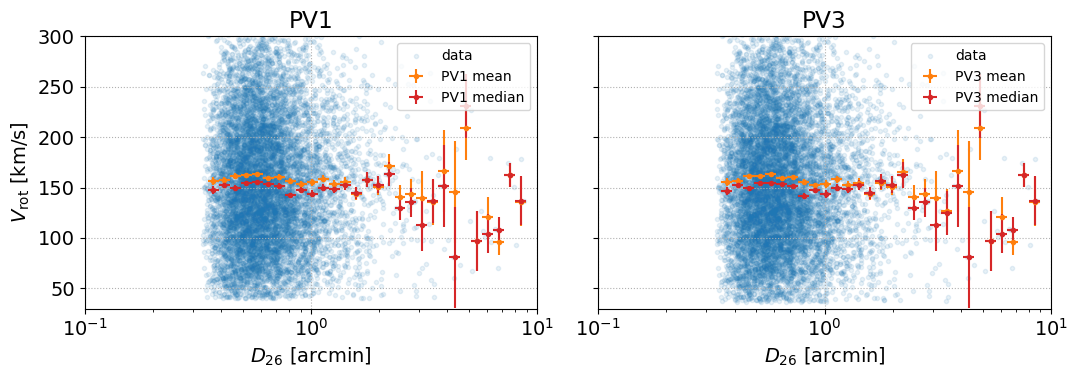

In [14]:
xbins = np.logspace(np.log10(0.35), 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'D26'
yval = 'V_0p4R26'
yval_err = 'V_0p4R26_err'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0.1, 10],
       xscale='log',
       ylim=[30, 300],
       xlabel=r'$D_{26}$ [arcmin]',
       ylabel=r'$V_\text{rot}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$D_{26}$ [arcmin]')
ax.grid(ls=':')

### Rotational velocity vs redshift

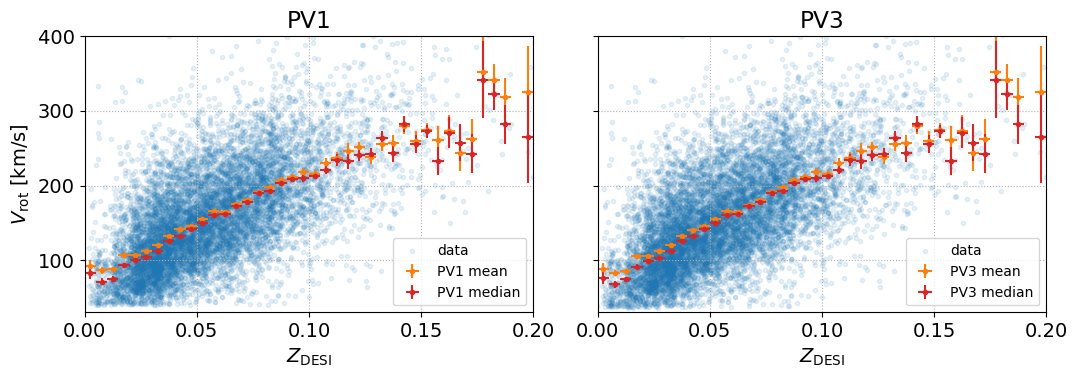

In [15]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'V_0p4R26'
yval_err = 'V_0p4R26_err'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 0.2],
       ylim=[30, 400],
       xlabel=r'$Z_\text{DESI}$',
       ylabel=r'$V_\text{rot}$ [km/s]')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='lower right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$Z_\text{DESI}$')
ax.grid(ls=':')

### Magnitude vs Redshift

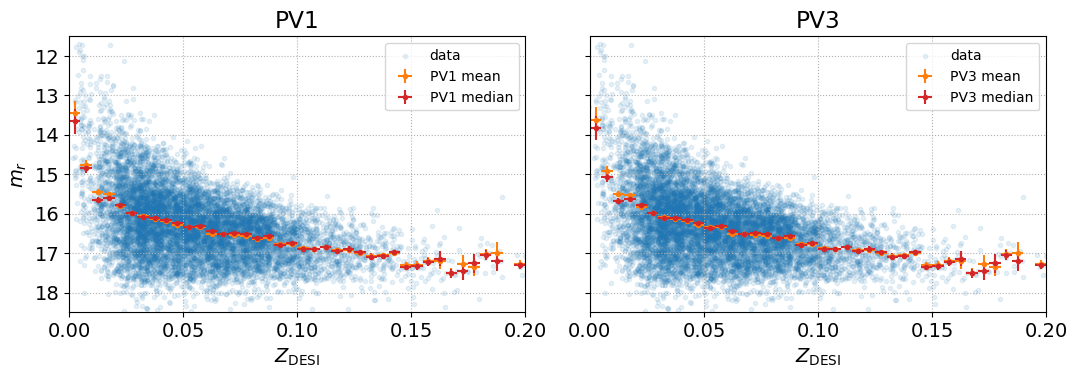

In [16]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'R_MAG_SB26'
yval_err = 'R_MAG_SB26_ERR'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 0.2],
       ylim=[18.5, 11.5],
       xlabel=r'$Z_\text{DESI}$',
       ylabel=r'$m_r$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$Z_\text{DESI}$')
ax.grid(ls=':')

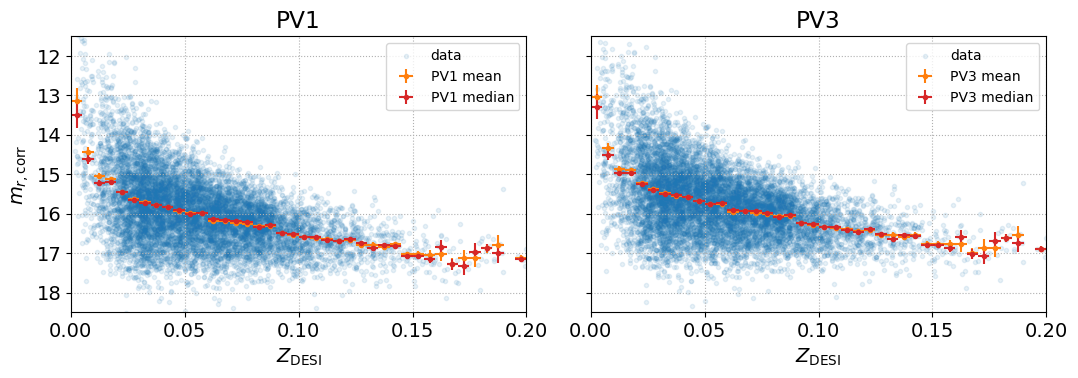

In [17]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'R_MAG_SB26_CORR'
yval_err = 'R_MAG_SB26_CORR_ERR'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 0.2],
       ylim=[18.5, 11.5],
       xlabel=r'$Z_\text{DESI}$',
       ylabel=r'$m_{r,\text{corr}}$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='upper right', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$Z_\text{DESI}$')
ax.grid(ls=':')

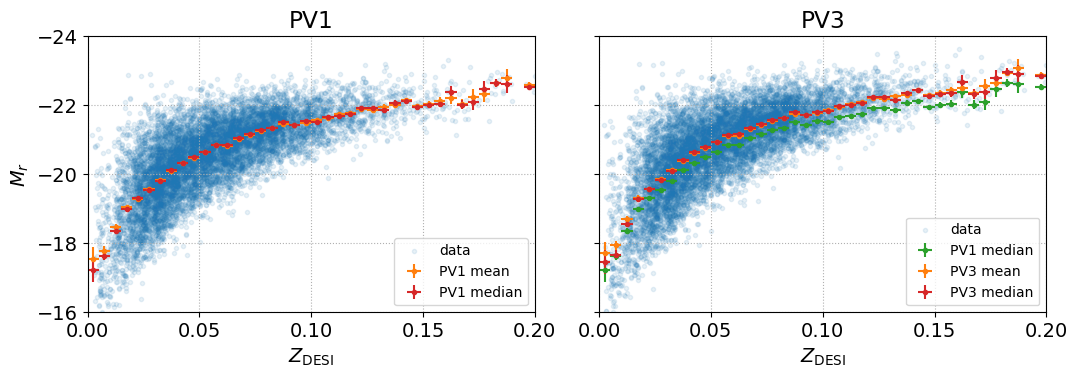

In [18]:
xbins = np.linspace(0, 0.2, 41)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'Z_DESI'
yval = 'R_ABSMAG_SB26'
yval_err = 'R_ABSMAG_SB26_ERR'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, tab1[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 0.2],
       ylim=[-16, -24],
       xlabel=r'$Z_\text{DESI}$',
       ylabel=r'$M_r$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:green')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err])
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, tab3[yval_err], median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$Z_\text{DESI}$')
ax.grid(ls=':')

### Color vs Peculiar Velocity and Axis Ratio

Plot $g-r$ and $r-z$ vs derived PV and galaxy properties.

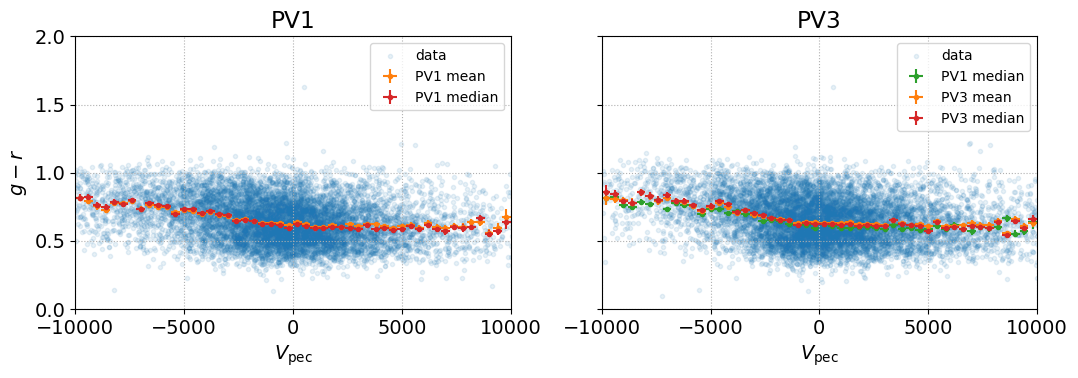

In [19]:
xbins = np.linspace(-10000, 10000, 51)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'V_PEC'
yval = 'g-r'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV1',
       xlim=[-1e4, 1e4],
       ylim=[0, 2],
       xlabel=r'$V_\text{pec}$',
       ylabel=r'$g-r$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:green')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$V_\text{pec}$')
ax.grid(ls=':')

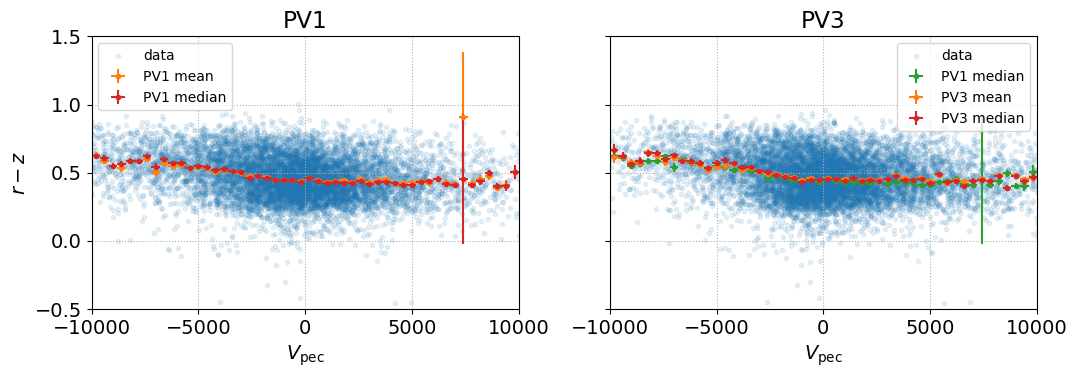

In [20]:
xbins = np.linspace(-10000, 10000, 51)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'V_PEC'
yval = 'r-z'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV1',
       xlim=[-1e4, 1e4],
       ylim=[-0.5, 1.5],
       xlabel=r'$V_\text{pec}$',
       ylabel=r'$r-z$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:green')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$V_\text{pec}$')
ax.grid(ls=':')

/tmp/ipykernel_409210/3014246524.py:42: RuntimeWarning: divide by zero encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))
/tmp/ipykernel_409210/3014246524.py:42: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt((mean2 - mean**2) / (N - 1))


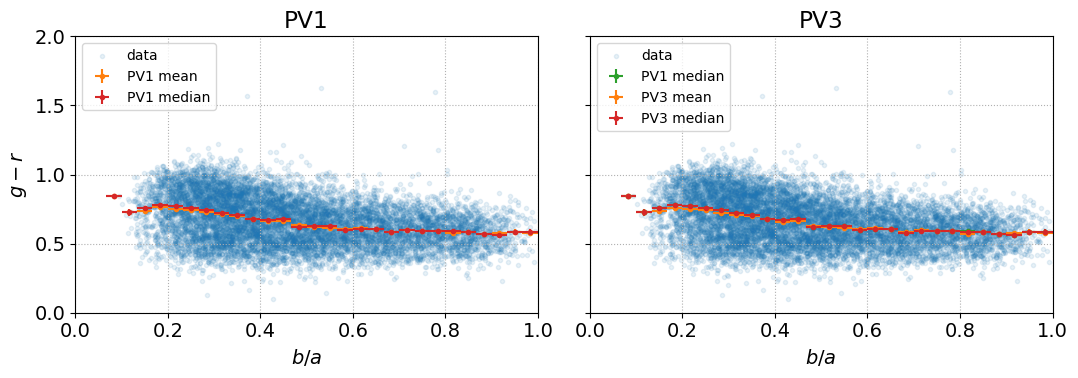

In [21]:
xbins = np.linspace(0, 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'g-r'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[0, 2],
       xlabel=r'$b/a$',
       ylabel=r'$g-r$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:green')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$b/a$')
ax.grid(ls=':')

/tmp/ipykernel_409210/3014246524.py:42: RuntimeWarning: divide by zero encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


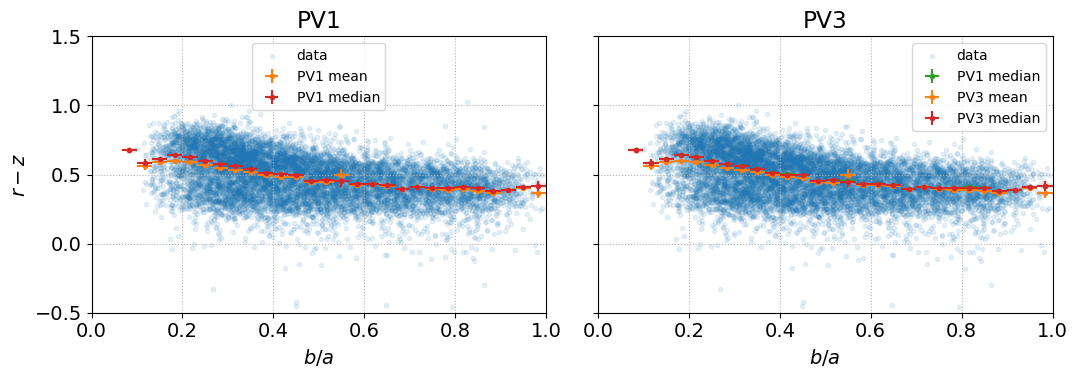

In [22]:
xbins = np.linspace(0, 1, 31)
dx = 0.5*np.diff(xbins)
xc = 0.5*(xbins[1:] + xbins[:-1])

xval = 'BA'
yval = 'r-z'

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.scatter(tab1[xval], tab1[yval], marker='.', alpha=0.1, label='data')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab1[xval], tab1[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV1',
       xlim=[0, 1],
       ylim=[-0.5, 1.5],
       xlabel=r'$b/a$',
       ylabel=r'$r-z$')
ax.grid(ls=':')

ax = axes[1]
ax.scatter(tab3[xval], tab3[yval], marker='.', alpha=0.1, label='data')

#- Plot PV1
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV1 median', color='tab:green')

#- Plot mean and median
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 mean', color='tab:orange')
N, y_avg, y_std = profile_histogram(tab3[xval], tab3[yval], xbins, median=True)
ax.errorbar(xc, y_avg, xerr=dx, yerr=y_std, fmt='.', label='PV3 median', color='tab:red')

ax.legend(loc='best', fontsize=10)
ax.set(title='PV3',
       xlabel=r'$b/a$')
ax.grid(ls=':')

In [23]:
# isbig = d26 > 2

# fig, ax = plt.subplots(1,1, figsize=(3,9), tight_layout=True)

# ax.scatter(logvrot[~isbig], Mr26[~isbig], marker='.', alpha=0.2)
# ax.scatter(logvrot[isbig], Mr26[isbig], marker='.', alpha=0.5)

# ax.set(xlim=(0.5, 3),
#        ylim=(-12,-28));